### Step 1. KITTI 데이터셋 수집과 구축
>다운받아 둔 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 내부적인 메모리 사용량이 U-Net보다 꽤 많아집니다. 8GB의 GPU 메모리를 가진 모델의 경우 학습데이터의 배치 사이즈를 16->4 로 줄여서 설정하시기를 권합니다.

In [25]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

In [26]:
def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

In [27]:
class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self,
                dir_path,
                batch_size = 4,
                img_size=(224,224,3),
                output_size=(224,224),
                is_train=True,
                augmentation=None):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        #load_dataset()을 통해서 kitti dataset의 directory path에서
        #라벨과 이미지를 확인한다.
        self.data = self.load_dataset()
        
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.    
        input_images = glob(os.path.join(self.dir_path, "image_2","*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic","*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [_ for _ in zip(input_images, label_images)]
        
        if self.is_train:
            return data[:-30]
        return data[-30:]
        
    def __len__(self):
        return math.ceil(len(self.data)/self.batch_size)

    def __getitem__(self, index):
        #입력과 출력을 만든다.
        #입력은 resize 및 augmentation이 적용된 input image이고
        #출력은 semantic label이다.
        batch_data = self.data[
            index*self.batch_size : (index+1)*self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        #data에서 배치만큼 가져온 것 (input과 label image가 같이 들어있다)
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image" : _input,
                "mask" : _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs

    def on_epoch_end(self):
        #한 에폭이 끝나면 실행되는 함수이다. 학습중인 경우에 순서를 random shuffle하도록 적용하는
        #것을 볼수 있다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True:
            np.random.shuffle(self.indexes)
            return self.indexes

In [28]:
dir_path = "/home/aiffel0042/aiffel/semantic_segmentation/data/training"
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
train_generator = KittiGenerator(dir_path,
                                augmentation=augmentation,)
test_generator = KittiGenerator(dir_path,
                                augmentation=test_preproc,
                                is_train=False
                               )

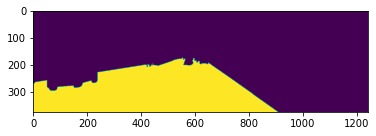

In [29]:
#class에 해당하는 픽셀들은 label을 넘버를 픽셀값으로 가지고 있다.
img = Image.open("/home/aiffel0042/aiffel/semantic_segmentation/data/training/semantic/000001_10.png")
img_ar = np.array(img)
plt.imshow(np.where(img_ar==7,255,0)) #7은 도로를 나타낸다.

### Step 2. U-Net++ 모델의 구현
>U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다.
그 외 적절히 U-Net이 백본구조, 기타 파라미터 변경 등을 통해 추가적인 성능향상이 가능할수도 있습니다.

In [51]:
from Unetplusplus import UNETPP

In [59]:
tf.keras.backend.clear_session()
my_model = UNETPP(first_filter=32)
my_model.get_summary(plotting=False)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
convblock (Convblock)           (None, 224, 224, 32) 10400       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    multiple             0           convblock[0][0]                  
                                                                 convblock_1[0][0]                
                                                                 convblock_2[0][0]                
                                                                 convblock_3[0][0]     

In [60]:
my_model.build((None,224,224,3))

In [61]:
def my_loss():
    def dice_coef(y_true, y_pred):
        y_true_f = tf.keras.backend.flatten(y_true)
        y_pred_f = tf.keras.backend.flatten(y_pred)
        intersection = tf.keras.backend.sum(y_true_f*y_pred_f)
        return (2. * intersection + tf.keras.backend.epsilon()/(tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f)+tf.keras.backend.epsilon()))

    def dice_coef_loss(y_true, y_pred):
        return 1-dice_coef(y_true,y_pred)

    def bce_dice_loss(y_true, y_pred):
        loss = tf.keras.losses.binary_crossentropy(y_true,y_pred) + dice_coef_loss(y_true,y_pred)
        return loss
    
    return bce_dice_loss

def bce_dice_loss():
    def f_score(gt, pr, class_weights=1, beta=1, smooth=1, per_image=True, threshold=None):
        if per_image:
            axes = [1, 2]
        else:
            axes = [0, 1, 2]
        if threshold is not None:
            pr = tf.keras.backend.greater(pr, threshold)
            pr = tf.keras.backend.cast(pr, K.floatx())
        tp = tf.keras.backend.sum(gt * pr, axis=axes)
        fp = tf.keras.backend.sum(pr, axis=axes) - tp
        fn = tf.keras.backend.sum(gt, axis=axes) - tp
        score = ((1 + beta ** 2) * tp + smooth) \
                / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
        # mean per image
        if per_image:
            score = tf.keras.backend.mean(score, axis=0)
        # weighted mean per class
        score = tf.keras.backend.mean(score * class_weights)
        return score
    def dice_loss(gt, pr, class_weights=1., smooth=1, per_image=True, beta=1.):
        return 1 - f_score(gt, pr, class_weights=class_weights, smooth=smooth, per_image=per_image, beta=beta)
    def bce_dice(gt, pr, bce_weight=1., smooth=1, per_image=True, beta=1.):
        bce = tf.keras.backend.mean(tf.keras.losses.binary_crossentropy(gt, pr))
        loss = bce_weight * bce + dice_loss(gt, pr, smooth=smooth, per_image=per_image, beta=beta)
        return loss
    return bce_dice

In [62]:
my_model.compile(optimizer=Adam(lr=1e-4), loss=bce_dice_loss())

In [ ]:
my_model.fit_generator(
    generator=train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
)

model_path = os.path.join(os.getenv("HOME"),"project/Going_deeper/GD_U-Net") + '/seg_model_weights_unetpp.h5'
my_model.save_weights(model_path,save_format='h5')

new_model = UNETPP(first_filter=32)
new_model.build((None,224,224,3))

new_model.load_weights(filepath=model_path)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



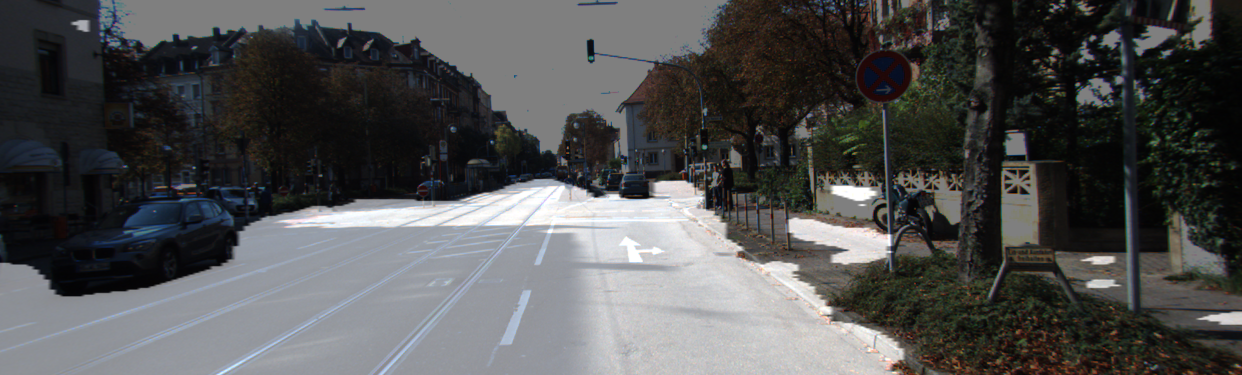

In [64]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    
    return output
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     my_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [66]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [68]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     my_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.897969


0.8979694338810361

### Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
>두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

![image](https://user-images.githubusercontent.com/63500940/97539930-28b4de00-1a06-11eb-8331-3f07c87328ef.png)

### 정리
  
U-Net++를 구현하고 KITTI 데이터셋으로 도로 영역 검출(segmentation)을 수행하였다.  
기존의 U-Net 모델과 비교하였을때, 동일 테스트 이미지에 대하여 IoU 점수가 0.812 대 0.897로  
U-Net++가 더 좋은 성능을 보였다.  
  
모델 구현에서 어려웠던 점은 여러 텐서들이 연결되는 부분을 shape을 신경쓰면서 해줘야한다는 점이 었다.  
  
모델에서 Loss function으로 Binary Cross Entropy와 dice coefficent loss의 합을 사용한다는 점이  
Segmentation 테스크의 특징이다.  
  
모델을 직접 구현해보고, Custom loss function을 직접 구현해볼 수 있는 기회였다.